In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
#!wget --no-check-certificate \
#    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
#    -O /tmp/daily-min-temperatures.csv

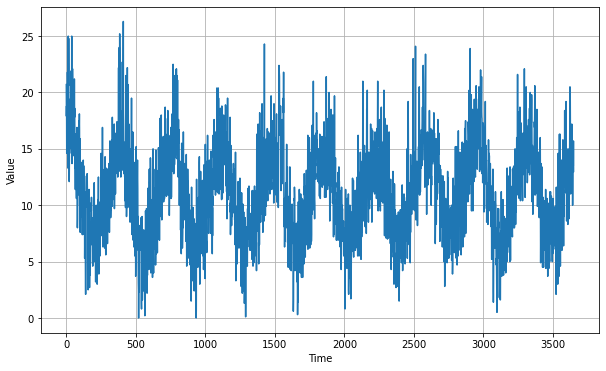

In [3]:
import csv
time_step = []
temps = []

with open('../../data/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 7s 70ms/step - loss: 31.0288 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 0s 20ms/step - loss: 30.7697 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 0s 22ms/step - loss: 18.2363 - mae: 18.7316
Epoch 10/100
10/10 [=====

10/10 [==============================] - 0s 21ms/step - loss: 5.8601 - mae: 6.3513
Epoch 86/100
10/10 [==============================] - 0s 21ms/step - loss: 7.3590 - mae: 7.8541
Epoch 87/100
10/10 [==============================] - 0s 21ms/step - loss: 12.9752 - mae: 13.4611
Epoch 88/100
10/10 [==============================] - 0s 21ms/step - loss: 38.9384 - mae: 39.4383
Epoch 89/100
10/10 [==============================] - 0s 22ms/step - loss: 34.0327 - mae: 34.5281
Epoch 90/100
10/10 [==============================] - 0s 20ms/step - loss: 41.1582 - mae: 41.6526
Epoch 91/100
10/10 [==============================] - 0s 21ms/step - loss: 45.5814 - mae: 46.0810
Epoch 92/100
10/10 [==============================] - 0s 21ms/step - loss: 75.2966 - mae: 75.7957
Epoch 93/100
10/10 [==============================] - 0s 21ms/step - loss: 38.5681 - mae: 39.0609
Epoch 94/100
10/10 [==============================] - 0s 21ms/step - loss: 36.4261 - mae: 36.9256
Epoch 95/100
10/10 [=================

(1e-08, 0.0001, 0.0, 60.0)

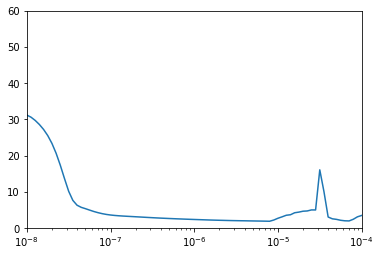

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 3s 13ms/step - loss: 15.8471 - mae: 16.3395
Epoch 2/150
25/25 [==============================] - 0s 12ms/step - loss: 2.9319 - mae: 3.4000
Epoch 3/150
25/25 [==============================] - 0s 11ms/step - loss: 2.0154 - mae: 2.4716
Epoch 4/150
25/25 [==============================] - 0s 12ms/step - loss: 1.9116 - mae: 2.3667
Epoch 5/150
25/25 [==============================] - 0s 11ms/step - loss: 1.8753 - mae: 2.3298
Epoch 6/150
25/25 [==============================] - 0s 11ms/step - loss: 1.8385 - mae: 2.2917
Epoch 7/150
25/25 [==============================] - 0s 12ms/step - loss: 1.8145 - mae: 2.2668
Epoch 8/150
25/25 [==============================] - 0s 11ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 0s 11ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 0s 12ms/step - loss: 1.7409 - mae: 2.1911
Epoch 11/150
25/25 [===========================

25/25 [==============================] - 0s 12ms/step - loss: 1.5327 - mae: 1.9751
Epoch 87/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5347 - mae: 1.9767
Epoch 88/150
25/25 [==============================] - 0s 14ms/step - loss: 1.5338 - mae: 1.9758
Epoch 89/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5299 - mae: 1.9721
Epoch 90/150
25/25 [==============================] - 0s 13ms/step - loss: 1.5380 - mae: 1.9804
Epoch 91/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5291 - mae: 1.9712
Epoch 92/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5300 - mae: 1.9723
Epoch 93/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5270 - mae: 1.9691
Epoch 94/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5341 - mae: 1.9768
Epoch 95/150
25/25 [==============================] - 0s 12ms/step - loss: 1.5335 - mae: 1.9763
Epoch 96/150
25/25 [==============================] -

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

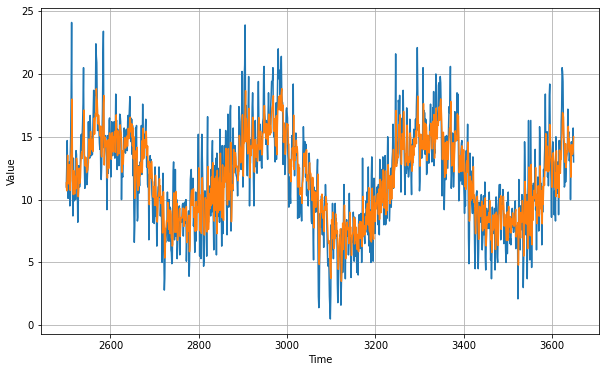

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796223

In [13]:
print(rnn_forecast)

[11.329564 10.705729 12.125057 ... 13.604387 13.796703 15.009257]
